In [1]:
import pandas as pd
import re
import os
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
from shapely.geometry import Point, MultiPolygon
from urllib3.util import Retry
from tenacity import retry, stop_after_attempt, wait_exponential
from shapely.ops import nearest_points
from requests.adapters import HTTPAdapter
from concurrent.futures import ThreadPoolExecutor, as_completed
import folium
import math
import pyproj
from itertools import chain
from pandas.plotting import scatter_matrix 
import seaborn as sns
from sklearn.neighbors import BallTree
from sklearn import set_config
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from dbfread import DBF
from sklearn.preprocessing import LabelEncoder
from functools import reduce
from scipy.stats import skew


from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import skew


from sklearn.feature_selection import RFECV

from sklearn.model_selection import RandomizedSearchCV




set_config(display='diagram')

# ML Pipeline

In [2]:
Features = pd.read_csv('CSV/All.csv')

In [3]:
Features.columns.tolist()

['WardID',
 'Exist',
 'DNExist',
 'People',
 'Potholes',
 'Trash',
 'Cars',
 'Buses',
 'Motorbikes',
 'Trucks',
 'NuPhotos',
 'PotholeRatio',
 'PeopleRatio',
 'TrashRatio',
 'CarRatio',
 'BusRatio',
 'TruckRatio',
 'MotorbikeRatio',
 'NuRoads',
 'RoadRatio',
 'artificial dams (including canals)',
 'artificial flooded mine pits',
 'artificial sewage ponds',
 'bare riverbed material',
 'coastal sand & dunes',
 'commercial',
 'commercial annual crops non-pivot irrigated',
 'commercial annual crops pivot irrigated',
 'commercial annual crops rain-fed / dryland',
 'contiguous & dense plantation forest',
 'contiguous (indigenous) forest',
 'contiguous low forest & thicket',
 'cultivated commercial permanent orchards',
 'cultivated commercial permanent pineapples',
 'cultivated commercial permanent vines',
 'cultivated commercial sugarcane non-pivot',
 'cultivated commercial sugarcane pivot irrigated',
 'cultivated emerging farmer sugarcane non-pivot',
 'dense forest & woodland',
 'dry pans',

In [4]:
Features

,WardID,Exist,DNExist,People,Potholes,Trash,Cars,Buses,Motorbikes,Trucks,...,RoadLag,PotholeLagDifference,PeopleLagDifference,TrashLagDifference,CarLagDifference,BusLagDifference,TrucklagDifference,MotorbikeLagDifference,RoadLagDifffference,PeopleCarRatio
0,10503001,49,96,4,24,5,15,0,6,1,...,0.113075,0.130483,-0.158909,-0.157210,0.179886,-0.005291,0.005547,-0.080474,0.224856,0.266667
1,10503002,124,159,23,6,6,53,2,4,3,...,0.488273,-0.233701,0.008684,-0.028813,0.001863,0.011494,0.004297,-0.012216,-0.050110,0.433962
2,10503003,35,63,6,17,6,14,0,0,1,...,0.425300,-0.078031,-0.012011,0.048193,-0.054291,0.000000,-0.008983,-0.035204,-0.068157,0.428571
3,10503004,54,71,6,14,3,24,0,3,1,...,0.400348,-0.253146,-0.059411,-0.040023,-0.028836,0.000000,-0.016883,0.005612,0.031652,0.250000
4,10503005,50,24,17,31,5,35,0,6,1,...,0.319122,0.073045,0.142290,0.002494,0.227967,0.000000,-0.013822,0.064796,0.356553,0.485714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3614,34501007,2,190,2,0,2,0,0,0,0,...,0.113291,-0.141636,0.082917,-0.027278,-0.216117,0.000000,-0.011905,-0.027778,-0.102874,2.000000
3615,34501008,2,84,0,0,0,0,0,1,0,...,0.030785,-0.012346,-0.133875,-0.060606,0.000000,0.000000,0.000000,0.147075,-0.007530,1.000000
3616,34501013,2,136,0,0,0,0,0,0,0,...,0.017638,-0.025641,-0.090909,-0.086247,-0.102564,0.000000,-0.025641,0.000000,-0.003145,1.000000
3617,34501014,2,209,0,1,1,4,0,0,1,...,0.071052,0.066170,-0.062561,0.055418,0.264682,0.000000,0.066170,0.000000,-0.061573,0.250000


In [5]:
streetViewParams = [
'NuPhotos',
'PotholeRatio',
'PeopleRatio',
'TrashRatio',
'CarRatio',
'BusRatio',
'TruckRatio',
'MotorbikeRatio',
'RoadRatio', 
'PotholeLagDifference',
'PeopleLagDifference',
'TrashLagDifference',
'CarLagDifference',
'BusLagDifference',
'TrucklagDifference',
'MotorbikeLagDifference',
'RoadLagDifffference',
'PeopleCarRatio']




# Scalling

In [6]:
target = 'ANC%'
ML = Features.copy()
ML = ML[['Province']+[target] + streetViewParams]
X_train, X_test, y_train, y_test = train_test_split(ML.drop([target], axis=1), ML[target], test_size=0.2, random_state=42)



In [7]:
# Function to find skewed features that need scaling
def find_features_to_scale(df, skew_threshold=0.5):
    # Identify numeric columns
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    # Calculate skewness for each numeric feature
    skewness = df[numeric_features].apply(lambda x: skew(x.dropna()))

    # Select skewed features
    skewed_features = skewness[abs(skewness) > skew_threshold].index.tolist()
    
    return skewed_features, numeric_features

In [8]:
YeoJohnsonTransformer = PowerTransformer(method='yeo-johnson')

YJ_pipeline = Pipeline([
    ("YJ", YeoJohnsonTransformer),
])

Remainder_pipeline = Pipeline([
    ("Standardize", StandardScaler()),
])

Encoder_pipeline = Pipeline([
    ("OneHot", OneHotEncoder(drop='first', dtype=int, handle_unknown='ignore')),
])

YJ_Attributes, all_numeric_features = find_features_to_scale(X_train)


Remainder_Attributes = list(set(all_numeric_features) - set(YJ_Attributes))


Encoder_Attributes = ['Province']

In [9]:
preprocessing = ColumnTransformer([
    ("Scalling", YJ_pipeline, YJ_Attributes),
    ("Standardise", Remainder_pipeline, Remainder_Attributes),
    ("OneHot", Encoder_pipeline, Encoder_Attributes),
])

preprocessing

ColumnTransformer(transformers=[('Scalling',
                                 Pipeline(steps=[('YJ', PowerTransformer())]),
                                 ['NuPhotos', 'PotholeRatio', 'PeopleRatio',
                                  'TrashRatio', 'CarRatio', 'BusRatio',
                                  'TruckRatio', 'MotorbikeRatio', 'RoadRatio',
                                  'PotholeLagDifference', 'PeopleLagDifference',
                                  'TrashLagDifference', 'CarLagDifference',
                                  'BusLagDifference', 'TrucklagDifference',
                                  'MotorbikeLagDifference', 'PeopleCarRatio']),
                                ('Standardise',
                                 Pipeline(steps=[('Standardize',
                                                  StandardScaler())]),
                                 ['RoadLagDifffference']),
                                ('OneHot',
                                 Pipeline(steps=[('OneHot',
                                                  OneHotEncoder(drop='first',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore'))]),
                                 ['Province'])])

In [10]:
processedDataTrain = preprocessing.fit_transform(X_train)
processedDataTest = preprocessing.fit_transform(X_test)



In [11]:
# Convert transformed data back to DataFrame
feature_names = (
    YJ_Attributes +
    Remainder_Attributes +
    preprocessing.named_transformers_["OneHot"].get_feature_names_out(Encoder_Attributes).tolist()
)


Temp = pd.DataFrame(processedDataTrain, columns=feature_names)
X_train = Temp

Temp = pd.DataFrame(processedDataTest, columns=feature_names)
X_test = Temp

# Linear Regression

In [12]:
# Create an instance of the LinearRegression model
lin_reg = LinearRegression()

# Fit the model to the training data
lin_reg.fit(X_train, y_train)

LinearRegression()

## Pre Feature Reduction

In [13]:
# Create an instance of the LinearRegression model
lin_reg = LinearRegression()

# Fit the model to the training data
lin_reg.fit(X_train, y_train)

LinearRegression()

In [14]:
cv_results = cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='r2')
# Print out cross-validation results
print(f"Cross-Validation R² Scores: {cv_results}")
print(f"Average R²: {cv_results.mean()}")

Cross-Validation R² Scores: [0.64138792 0.65668191 0.69659357 0.69688472 0.71465246 0.67182111
 0.69974052 0.63601476 0.68170873 0.66956042]
Average R²: 0.6765046119028932


In [15]:
# Cross-validation with the best model
cv_results = cross_val_score(lin_reg, X_test, y_test, cv=10, scoring='r2')
# Print out cross-validation results
print(f"Cross-Validation R² Scores: {cv_results}")
print(f"Average R²: {cv_results.mean()}")

Cross-Validation R² Scores: [0.74368215 0.54130061 0.58489964 0.75637819 0.63838572 0.70479746
 0.81593038 0.59242899 0.59765434 0.75048766]
Average R²: 0.6725945127826592


In [16]:
# Evaluate the best model from GridSearchCV
predictions = lin_reg.predict(X_test)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

# Print the final evaluation metrics for the test set
print(f"Final Test Set Results - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

Final Test Set Results - MAE: 11.329190681084636, MSE: 205.41267581886873, RMSE: 14.332225082619543, R²: 0.6916082843944844


/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


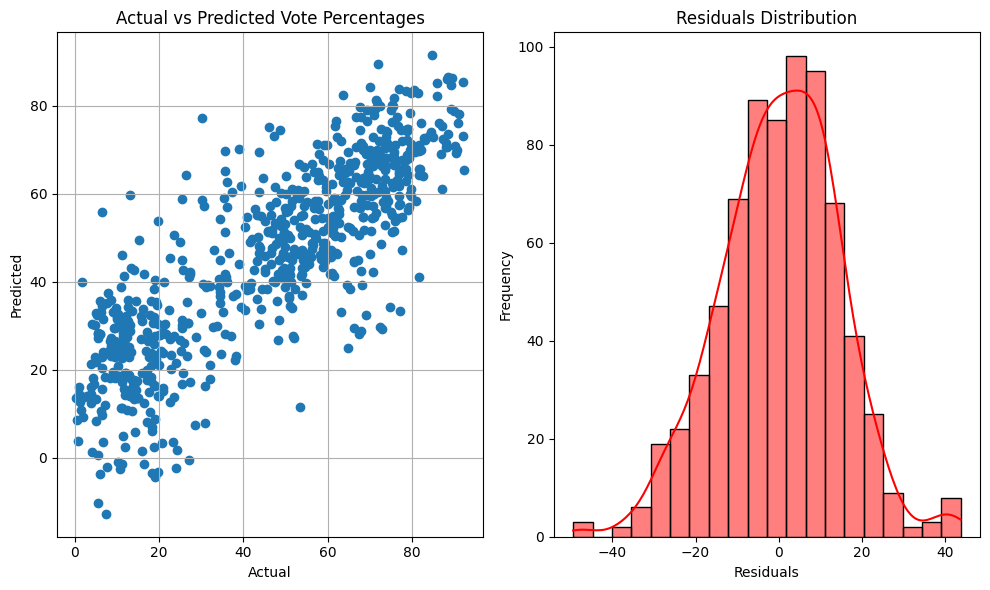

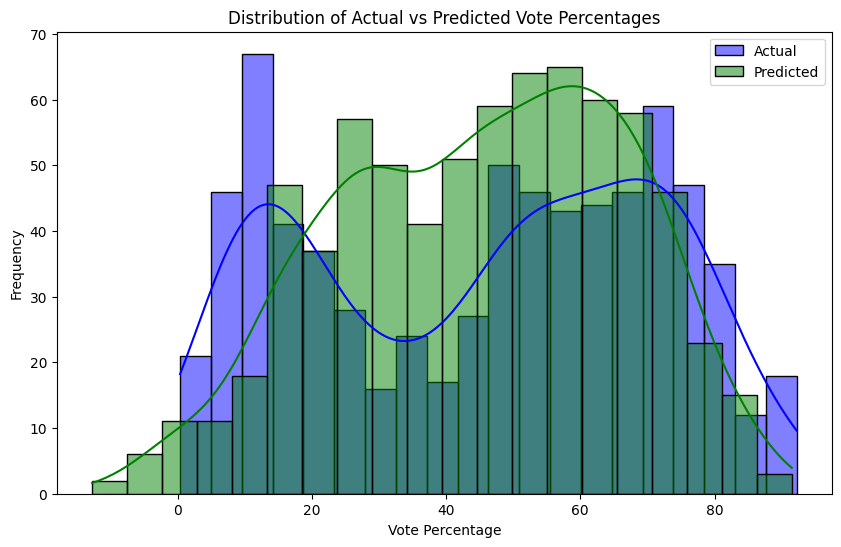

In [17]:

# Visualizing the Actual vs Predicted Vote Percentages
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions)
plt.title('Actual vs Predicted Vote Percentages')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# Residual Plot (Actual - Predicted)
residuals = y_test - predictions
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='red', bins=20)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Histograms of the actual data distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual', bins=20)
sns.histplot(predictions, kde=True, color='green', label='Predicted', bins=20)
plt.title('Distribution of Actual vs Predicted Vote Percentages')
plt.xlabel('Vote Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Feature Reduction

### RFE

In [18]:
# Initialize the model
model = LinearRegression()

# Apply RFECV (Recursive Feature Elimination with Cross-Validation)
selector = RFECV(model, step=1, cv=20, scoring='r2')  # Step size of 1, 20-fold cross-validation, and R² scoring

# Fit RFECV to the training data
selector.fit(X_train, y_train)

# Get the selected features (those with True in support_)
selected_features = X_train.columns[selector.support_]
print("Selected Features:", selected_features)
print(len(selected_features))

Selected Features: Index(['NuPhotos', 'PotholeRatio', 'PeopleRatio', 'TrashRatio', 'CarRatio',
       'BusRatio', 'TruckRatio', 'MotorbikeRatio', 'RoadRatio',
       'PotholeLagDifference', 'CarLagDifference', 'BusLagDifference',
       'TrucklagDifference', 'MotorbikeLagDifference', 'PeopleCarRatio',
       'RoadLagDifffference', 'Province_Free State', 'Province_Gauteng',
       'Province_KwaZulu-Natal', 'Province_Limpopo', 'Province_Mpumalanga',
       'Province_North West', 'Province_Northern Cape',
       'Province_Western Cape'],
      dtype='object')
24


In [19]:
X_train_selected = X_train[selected_features]  # Select only the features identified by RFECV
X_test_selected = X_test[selected_features]  

model = LinearRegression()
model.fit(X_train_selected, y_train)

LinearRegression()

In [20]:
# Cross-validation with the best model
cv_results = cross_val_score(model, X_train_selected, y_train, cv=10, scoring='r2')

# Print out cross-validation results
print(f"Cross-Validation R² Scores: {cv_results}")
print(f"Average R²: {cv_results.mean()}")

Cross-Validation R² Scores: [0.64143624 0.65687753 0.69611338 0.69656694 0.71440961 0.67348146
 0.69946728 0.63710958 0.68149283 0.66971151]
Average R²: 0.6766666372949891


In [21]:
# Cross-validation with the best model
cv_results = cross_val_score(model, X_test_selected, y_test, cv=10, scoring='r2')
# Print out cross-validation results
print(f"Cross-Validation R² Scores: {cv_results}")
print(f"Average R²: {cv_results.mean()}")

Cross-Validation R² Scores: [0.7399167  0.54048349 0.5895238  0.75682737 0.63436636 0.70230884
 0.81468927 0.5921306  0.59271355 0.75681913]
Average R²: 0.6719779127137597


In [22]:
# Evaluate the best model from GridSearchCV
predictions = model.predict(X_test_selected)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

# Print the final evaluation metrics for the test set
print(f"Final Test Set Results - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

Final Test Set Results - MAE: 11.347469776913899, MSE: 205.90503831773668, RMSE: 14.349391566116546, R²: 0.6908690869952956


/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


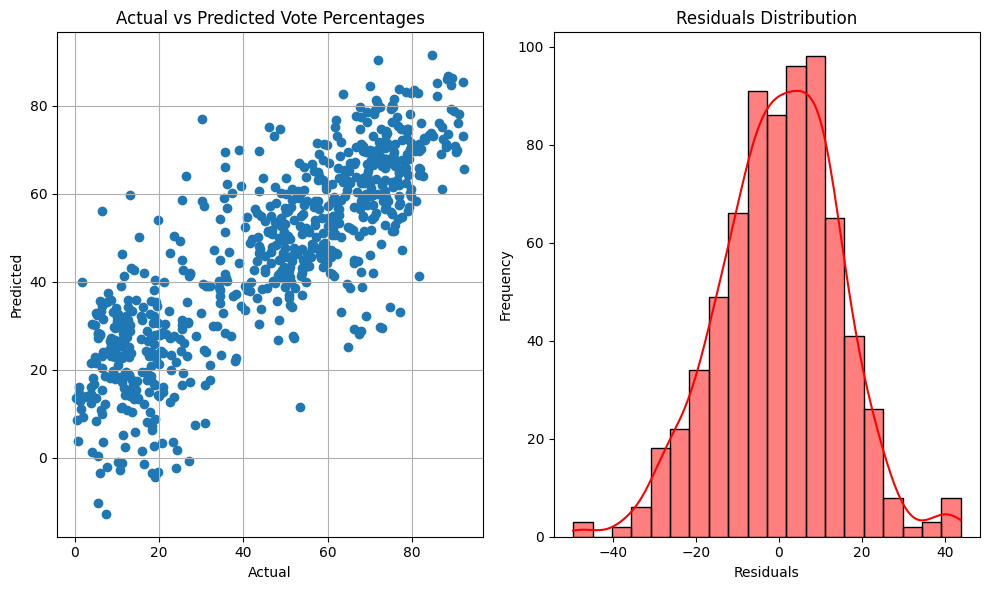

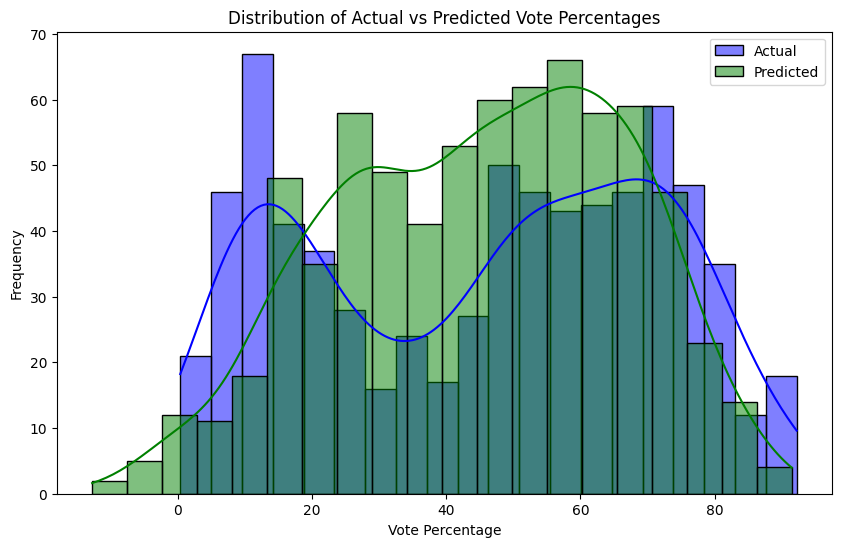

In [23]:

# Visualizing the Actual vs Predicted Vote Percentages
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions)
plt.title('Actual vs Predicted Vote Percentages')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# Residual Plot (Actual - Predicted)
residuals = y_test - predictions
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='red', bins=20)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Histograms of the actual data distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual', bins=20)
sns.histplot(predictions, kde=True, color='green', label='Predicted', bins=20)
plt.title('Distribution of Actual vs Predicted Vote Percentages')
plt.xlabel('Vote Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Random Forest

In [24]:
# Create an instance of the DecisionTreeRegressor model
rf_regressor = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Testing Pre HyperParam Tuning

In [25]:
# Cross-validation with the best model
cv_results = cross_val_score(rf_regressor, X_train, y_train, cv=10, scoring='r2')
# Print out cross-validation results
print(f"Cross-Validation R² Scores: {cv_results}")
print(f"Average R²: {cv_results.mean()}")

Cross-Validation R² Scores: [0.7241704  0.7209018  0.7627023  0.78809631 0.78824131 0.75080649
 0.79097613 0.75039332 0.74897743 0.74383105]
Average R²: 0.7569096534149065


In [26]:
# Cross-validation with the best model
cv_results = cross_val_score(rf_regressor, X_test, y_test, cv=10, scoring='r2')
# Print out cross-validation results
print(f"Cross-Validation R² Scores: {cv_results}")
print(f"Average R²: {cv_results.mean()}")

Cross-Validation R² Scores: [0.83456188 0.54446557 0.58934504 0.78854308 0.61311708 0.7854981
 0.84994418 0.5368466  0.72077057 0.80944855]
Average R²: 0.7072540629199576


In [27]:
# Evaluate the best model from GridSearchCV
predictions = rf_regressor.predict(X_test)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

# Print the final evaluation metrics for the test set
print(f"Final Test Set Results - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

Final Test Set Results - MAE: 9.460562025426205, MSE: 164.15514511211464, RMSE: 12.812304441907187, R²: 0.7535493531507407


/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


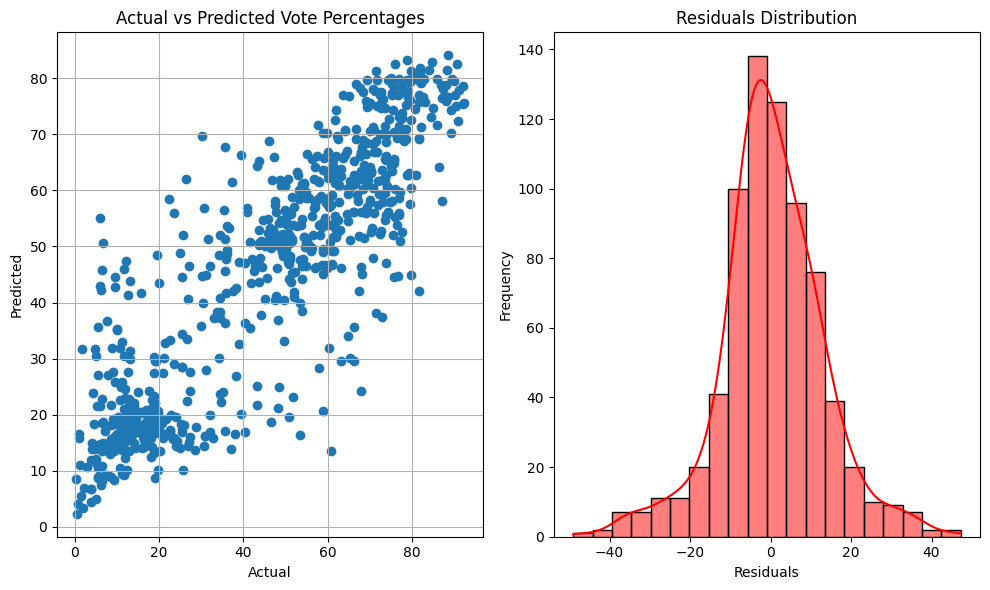

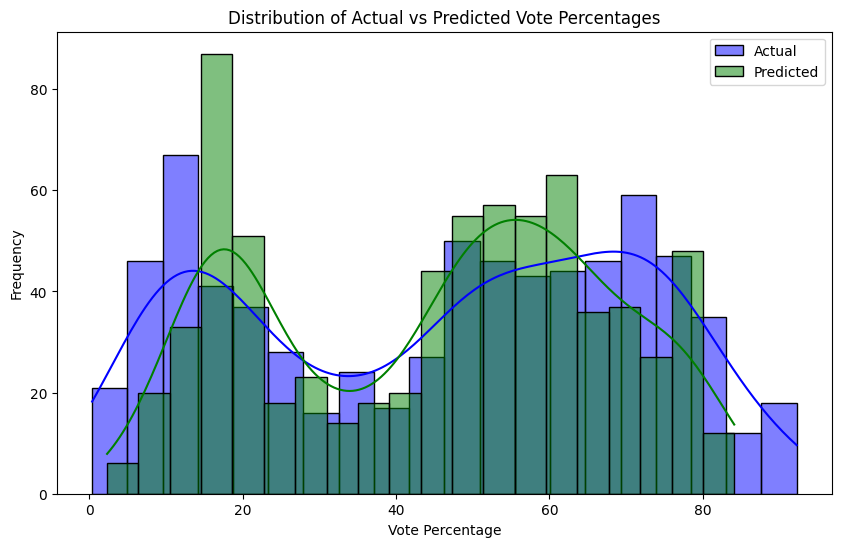

In [28]:
# Visualizing the Actual vs Predicted Vote Percentages
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions)
plt.title('Actual vs Predicted Vote Percentages')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# Residual Plot (Actual - Predicted)
residuals = y_test - predictions
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='red', bins=20)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Histograms of the actual data distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual', bins=20)
sns.histplot(predictions, kde=True, color='green', label='Predicted', bins=20)
plt.title('Distribution of Actual vs Predicted Vote Percentages')
plt.xlabel('Vote Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Hyper Param Selection

In [29]:
param_dist = {
    'n_estimators': [400, 500, 600, 700],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_leaf': [5, 10, 15, 20],
    'min_samples_split': [10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.5, 0.75],
    'bootstrap': [True, False]
}

# Set up RandomizedSearchCV with RandomForestRegressor
random_search = RandomizedSearchCV(rf_regressor, param_distributions=param_dist, 
                                   n_iter=50, cv=5, scoring='r2', n_jobs=-1, random_state=42)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best Parameters from RandomizedSearchCV: {random_search.best_params_}")
print(f"Best R² Score from RandomizedSearchCV: {random_search.best_score_}")

Best Parameters from RandomizedSearchCV: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 50, 'bootstrap': True}
Best R² Score from RandomizedSearchCV: 0.7560956225377177


### Testing post Hyper Param Selection

In [30]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

In [31]:
# Cross-validation with the best model
cv_results = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
# Print out cross-validation results
print(f"Cross-Validation R² Scores: {cv_results}")
print(f"Average R²: {cv_results.mean()}")

Cross-Validation R² Scores: [0.72035482 0.77341414 0.76309177 0.7734212  0.75019619]
Average R²: 0.7560956225377177


In [32]:
# Cross-validation with the best model
cv_results = cross_val_score(best_model, X_test, y_test, cv=5, scoring='r2')
# Print out cross-validation results
print(f"Cross-Validation R² Scores: {cv_results}")
print(f"Average R²: {cv_results.mean()}")

Cross-Validation R² Scores: [0.68683147 0.68524158 0.68763254 0.73570627 0.70649483]
Average R²: 0.7003813366762826


In [33]:
# Evaluate the best model from GridSearchCV
predictions = best_model.predict(X_test)

# Calculate the evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

# Print the final evaluation metrics for the test set
print(f"Final Test Set Results - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}")

Final Test Set Results - MAE: 9.627373946635387, MSE: 168.49168651716485, RMSE: 12.980434758403312, R²: 0.7470387839350559


/opt/miniconda3/envs/streerview/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


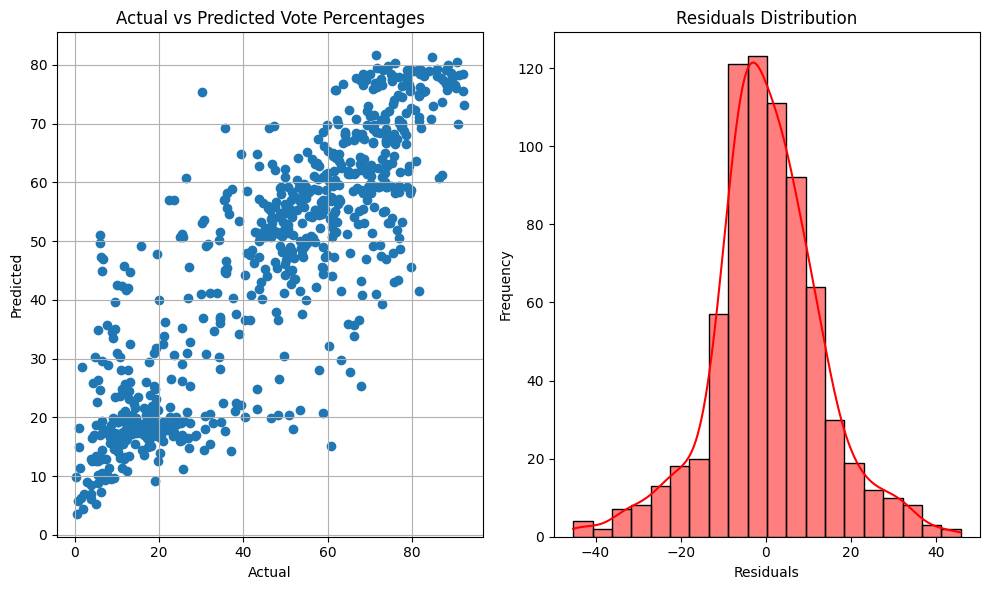

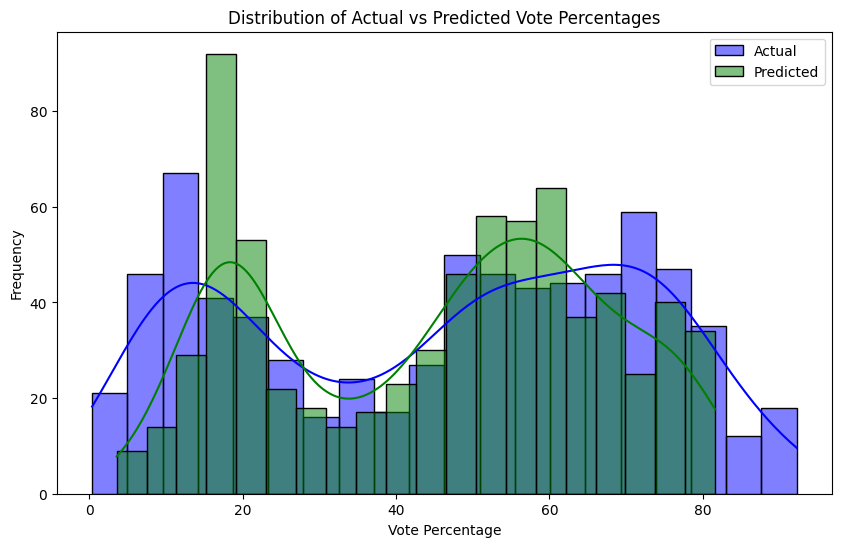

In [34]:

# Visualizing the Actual vs Predicted Vote Percentages
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, predictions)
plt.title('Actual vs Predicted Vote Percentages')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)

# Residual Plot (Actual - Predicted)
residuals = y_test - predictions
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='red', bins=20)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Histograms of the actual data distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual', bins=20)
sns.histplot(predictions, kde=True, color='green', label='Predicted', bins=20)
plt.title('Distribution of Actual vs Predicted Vote Percentages')
plt.xlabel('Vote Percentage')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Notes


## All Wards 
Linear Regression:
- **Before FRE:**
  - train: 0.6765046119028932
  - test: 0.6725945127826592

- **After FRE:**
  - train: R²: 0.6766666372949891
  - test: R²: 0.6719779127137597

Final Test Set Results - MAE: 11.347469776913899, MSE: 205.90503831773668, RMSE: 14.349391566116546, R²: 0.6908690869952956
  
Random Forest:
- **Before Tuning:**
  - train: 0.7569096534149065
  - test: 0.7072540629199576

- **After Tuning:**
  - train: R²: 0.7560956225377177
  - test: R²: 0.7003813366762826

Final Test Set Results - MAE: 9.627373946635387, MSE: 168.49168651716485, RMSE: 12.980434758403312, R²: 0.7470387839350559


## Metros
Linear Regression:
- **Before FRE:**
  - train: 0.7273717206171149
  - test: 0.7208513349461947

- **After FRE:**
  - train: R²: 0.7299533415376196
  - test: R²: 0.7056170241361475

Final Test Set Results - MAE: 10.768553990221537, MSE: 180.1923062337586, RMSE: 13.423572782004, R²: 0.7422998938148586

  
Random Forest:
- **Before Tuning:**
  - train: 0.8089449200640788
  - test: 0.7266174118947155

- **After Tuning:**
  - train: R²: 0.8078067261130599
  - test: R²: 0.6886886269855799

Final Test Set Results - MAE: 8.598664716467214, MSE: 143.82590511981834, RMSE: 11.992743852839448, R²: 0.7943089147576079


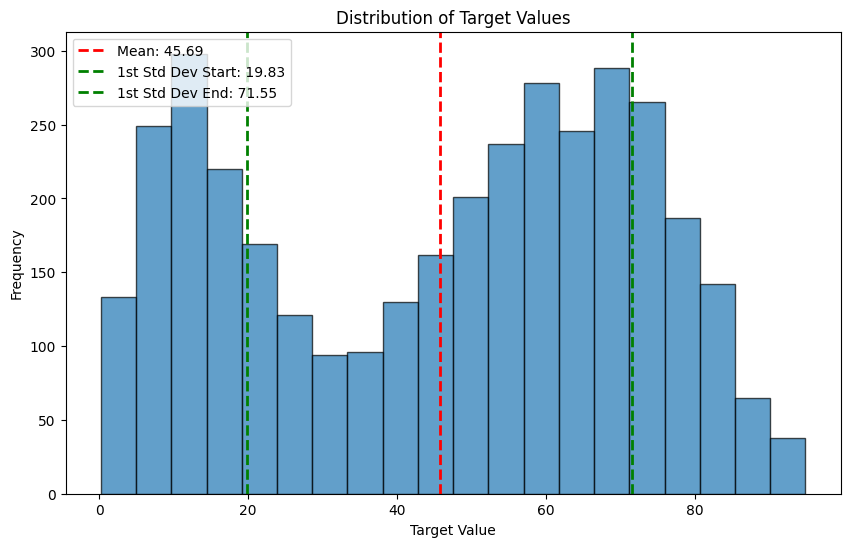

Variance: 668.5235527314103
Range: 94.57751549443243
Standard Deviation: 25.855822414524166
First Standard Deviation Range: [np.float64(19.83376934288493), np.float64(71.54541417193326)]


In [35]:
# Assuming 'Label' is the target array or list of target values
Label = Features[target].tolist()

# Convert to numpy array for convenience
Label = np.array(Label)

# Calculate variance, range, and first standard deviation
variance = np.var(Label)
range_value = np.max(Label) - np.min(Label)
std_dev = np.std(Label)
first_std_dev_range = [np.mean(Label) - std_dev, np.mean(Label) + std_dev]

# Plotting the target variable
plt.figure(figsize=(10,6))

# Plot the histogram of the target variable
plt.hist(Label, bins=20, edgecolor='black', alpha=0.7)

# Adding lines for mean and first standard deviation
plt.axvline(np.mean(Label), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(Label):.2f}')
plt.axvline(first_std_dev_range[0], color='green', linestyle='dashed', linewidth=2, label=f'1st Std Dev Start: {first_std_dev_range[0]:.2f}')
plt.axvline(first_std_dev_range[1], color='green', linestyle='dashed', linewidth=2, label=f'1st Std Dev End: {first_std_dev_range[1]:.2f}')

# Adding labels and title
plt.title('Distribution of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Frequency')

# Displaying legend
plt.legend()

# Show plot
plt.show()

# Returning the calculated values
print("Variance:", variance)
print("Range:", range_value)
print("Standard Deviation:", std_dev)
print("First Standard Deviation Range:", first_std_dev_range)


# Getting the most important features and displaying exploring those 

In [36]:
def CreateRadarChart(attributes, df):
    # The first attribute in the list will be used as the label
    label = attributes[0]

    # Compute Pearson and Spearman correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    corr_matrix_spearman = df[attributes].corr(method='spearman')

    # Get the top 6 correlation values based on absolute values for the specified label (first attribute in the list)
    pearson_values = corr_matrix_pearson[label].apply(abs).sort_values(ascending=False).head(7).values[1:]  # Excluding the label itself
    spearman_values = corr_matrix_spearman[label].apply(abs).sort_values(ascending=False).head(7).values[1:]

    # Labels for the radar chart (sorted based on absolute Pearson correlation)
    labels = corr_matrix_pearson[label].apply(abs).sort_values(ascending=False).head(7).index.tolist()[1:]  # Excluding the label itself

    # Make the radar chart 'close to a circle'
    pearson_values = np.concatenate((pearson_values, [pearson_values[0]]))
    spearman_values = np.concatenate((spearman_values, [spearman_values[0]]))
    
    # Number of variables (Top 6 features)
    num_vars = len(labels)

    # Compute angle for each axis of the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Add the first angle to make the chart 'close to a circle' 
    angles += angles[:1]

    # Set up the figure
    fig, ax = plt.subplots(figsize=(6, 6), dpi=100, subplot_kw=dict(polar=True))

    # Plot data
    ax.plot(angles, pearson_values, color='blue', linewidth=2, label='Pearson Correlation (Abs)')
    ax.fill(angles, pearson_values, color='blue', alpha=0.25)

    ax.plot(angles, spearman_values, color='red', linewidth=2, label='Spearman Correlation (Abs)')
    ax.fill(angles, spearman_values, color='red', alpha=0.25)

    # Labels and title
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, rotation=45, ha='right')

    plt.title(f"Top 6 Absolute Correlations for {label}: Pearson vs. Spearman", size=16)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()


In [37]:
def CorrelationCreation(attributes, df):
    # Compute Pearson and Spearman correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    corr_matrix_spearman = df[attributes].corr(method='spearman')

    # Print Pearson correlation for the first attribute
    print("\nPearson Correlation")
    print(corr_matrix_pearson[attributes[0]].sort_values(ascending=False))

    # Print Spearman correlation for the first attribute
    print("\nSpearman Correlation")
    print(corr_matrix_spearman[attributes[0]].sort_values(ascending=False))

    # Get the top features with the highest absolute correlation for both Pearson and Spearman
    top_pearson = corr_matrix_pearson[attributes[0]].apply(abs).sort_values(ascending=False).head(10).index.tolist()[1:]
    top_spearman = corr_matrix_spearman[attributes[0]].apply(abs).sort_values(ascending=False).head(10).index.tolist()[1:]

    # Get the top features to plot
    corr_matrix_pearson_top = corr_matrix_pearson.loc[top_pearson, top_pearson]
    corr_matrix_spearman_top = corr_matrix_spearman.loc[top_spearman, top_spearman]

    # Set up figure for heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Pearson Correlation Heatmap
    sns.heatmap(corr_matrix_pearson_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Pearson Correlation Heatmap")

    # Spearman Correlation Heatmap
    sns.heatmap(corr_matrix_spearman_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Spearman Correlation Heatmap")

    # Tight layout for heatmaps
    plt.tight_layout()
    plt.show()



    return top_pearson, top_spearman


In [38]:
def CreateScatterPlot(df,attributes):
    scatter_matrix(df[attributes], figsize=(20, 14))
    plt.show()
    return

## All Features


Pearson Correlation
ANC%                      1.000000
PeopleCarRatio            0.190288
PotholeLagDifference      0.088292
PotholeRatio              0.085806
PeopleRatio               0.085176
MotorbikeRatio            0.040984
TrashLagDifference        0.031513
MotorbikeLagDifference    0.025936
TrashRatio                0.013927
TrucklagDifference       -0.000211
BusLagDifference         -0.000747
PeopleLagDifference      -0.001158
BusRatio                 -0.006118
TruckRatio               -0.013010
CarLagDifference         -0.025112
RoadLagDifffference      -0.051285
CarRatio                 -0.166062
RoadRatio                -0.447259
NuPhotos                 -0.477148
Name: ANC%, dtype: float64

Spearman Correlation
ANC%                      1.000000
PeopleCarRatio            0.302442
PotholeLagDifference      0.092580
TrashLagDifference        0.025796
PotholeRatio              0.018047
MotorbikeLagDifference   -0.000382
BusLagDifference         -0.003788
PeopleRatio         

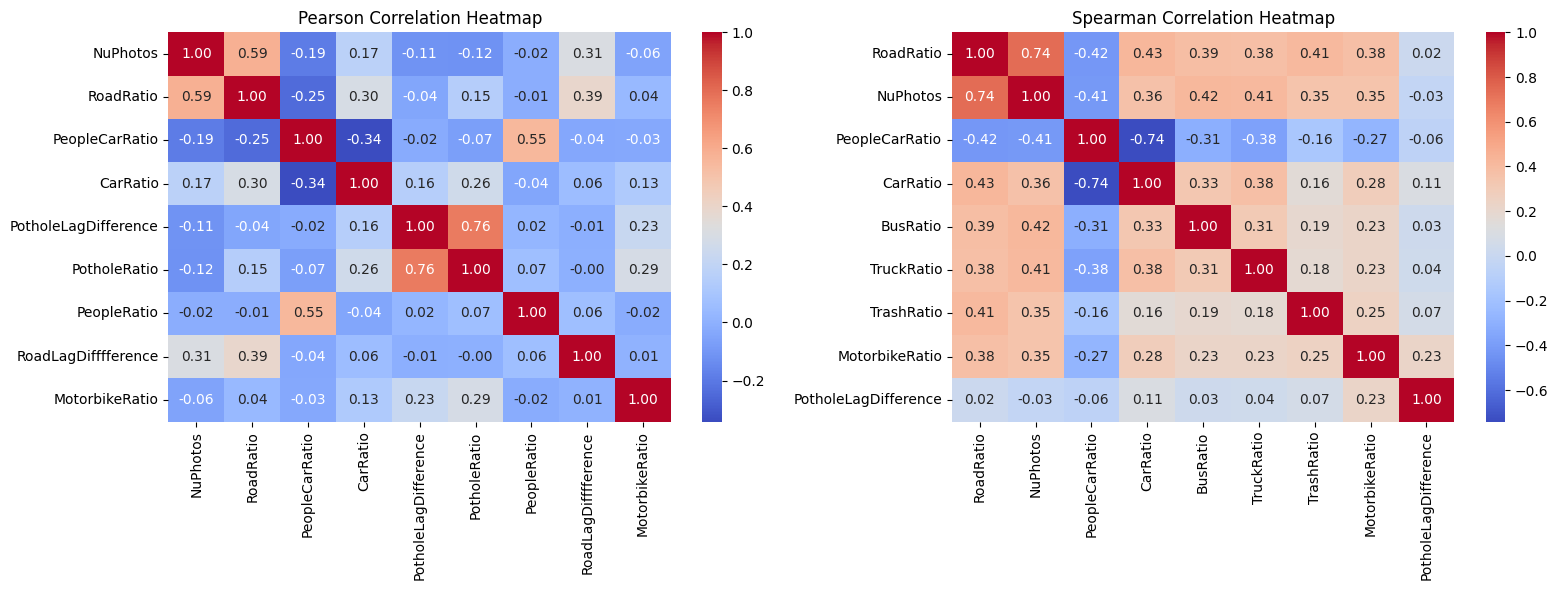

In [39]:
attributes = [target] + streetViewParams
toppearson, topspearmam = CorrelationCreation(attributes, Features)

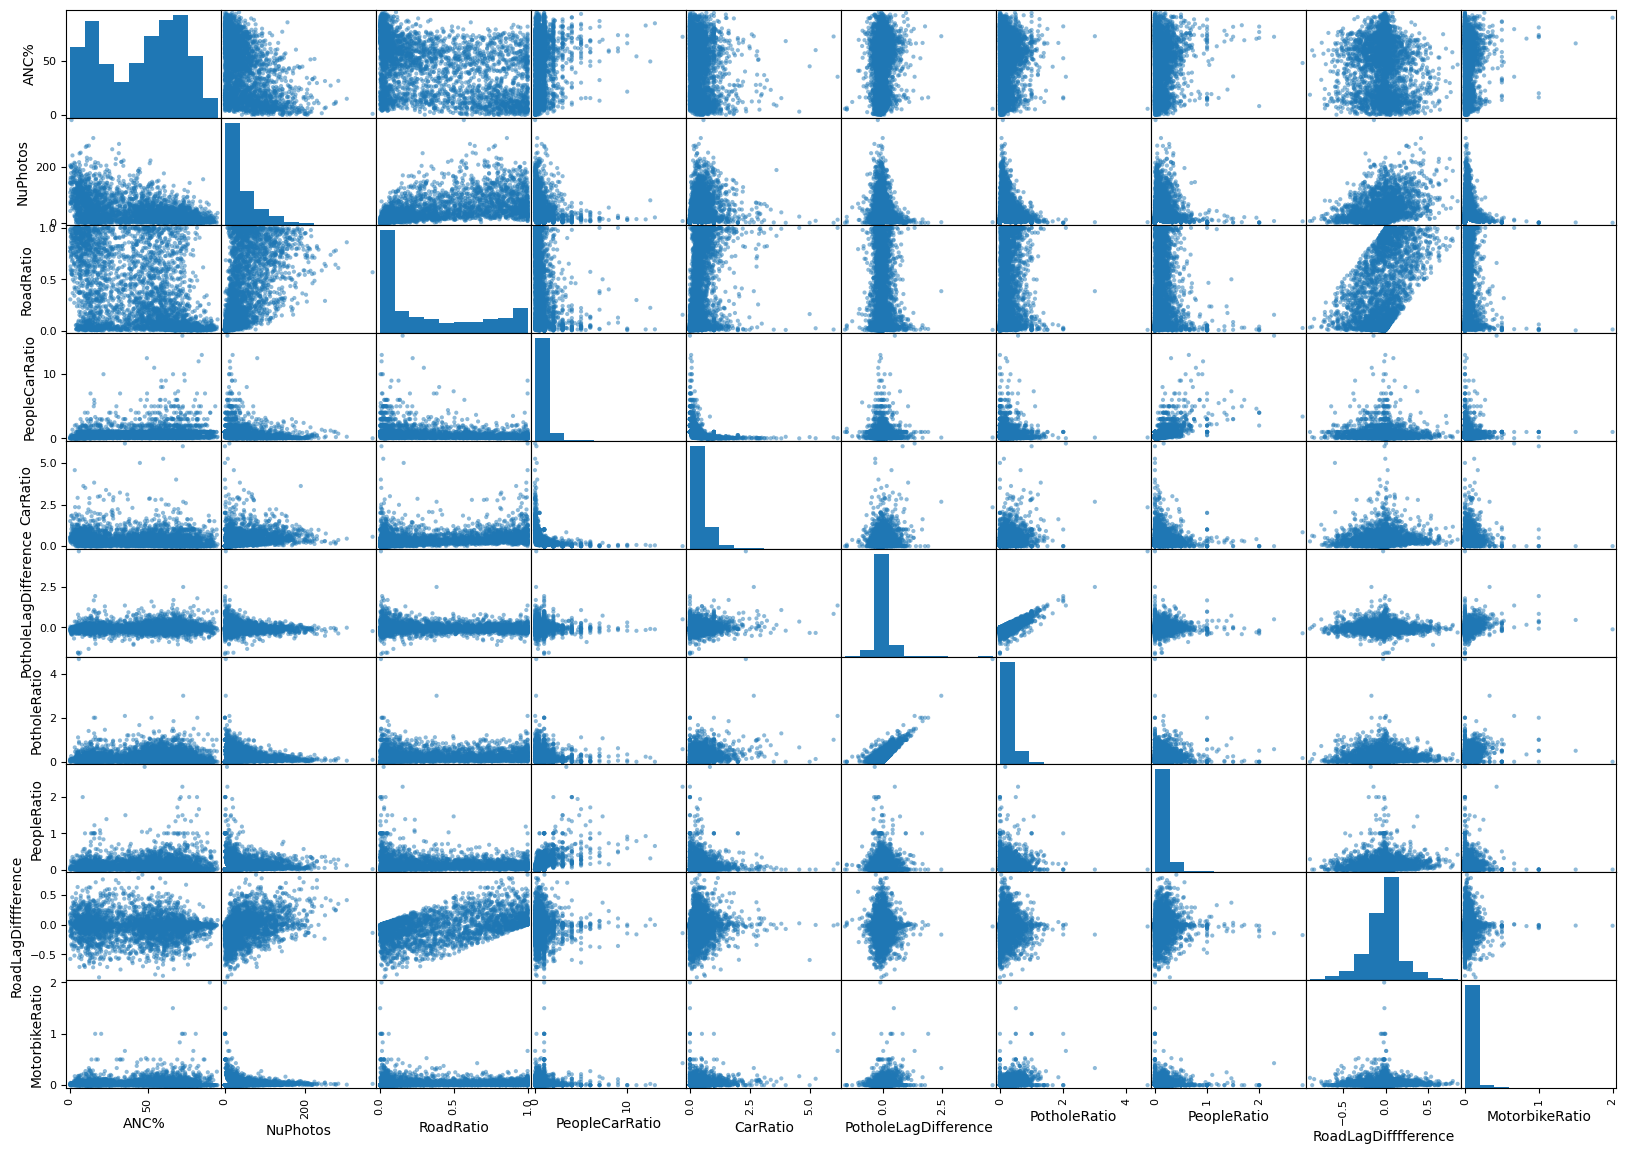

In [40]:
CreateScatterPlot(Features,[target] + toppearson)

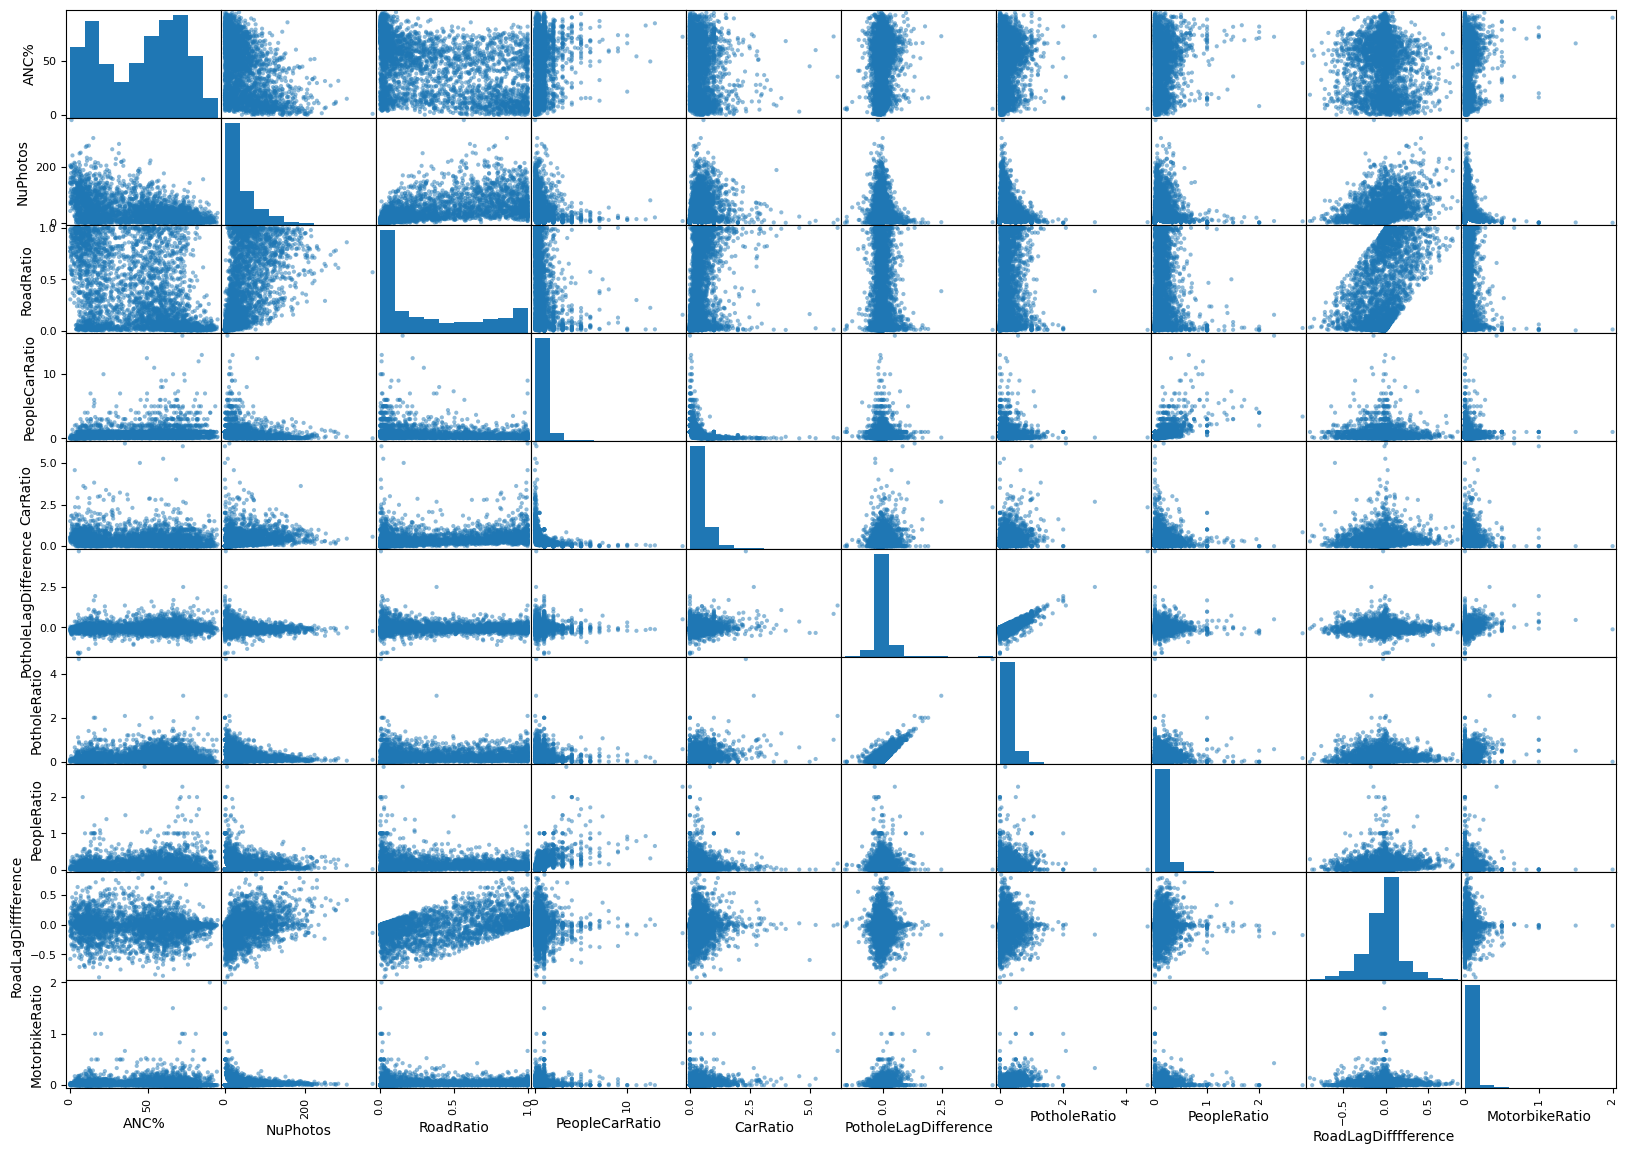

In [41]:
CreateScatterPlot(Features,[target] + toppearson)

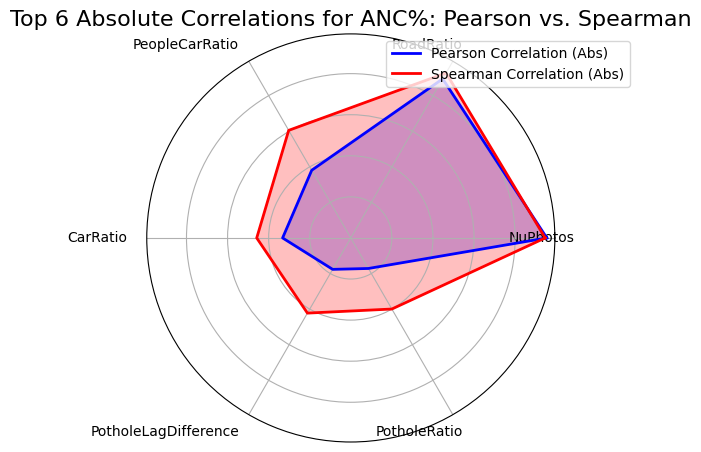

In [42]:
CreateRadarChart(attributes, Features)

## Important Features

In [43]:
# Get the feature importances from the trained model
importances = best_model.feature_importances_

# Create a DataFrame to display the feature names and their importances
feature_names = X_train.columns  # Assuming your data is in a DataFrame and X_train is the training data
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by their importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
feature_importance_df

,Feature,Importance
20,Province_KwaZulu-Natal,0.292910
0,NuPhotos,0.211064
8,RoadRatio,0.143045
21,Province_Limpopo,0.056819
1,PotholeRatio,0.055383
25,Province_Western Cape,0.035639
16,PeopleCarRatio,0.025481
17,RoadLagDifffference,0.022797
2,PeopleRatio,0.019146
3,TrashRatio,0.017348


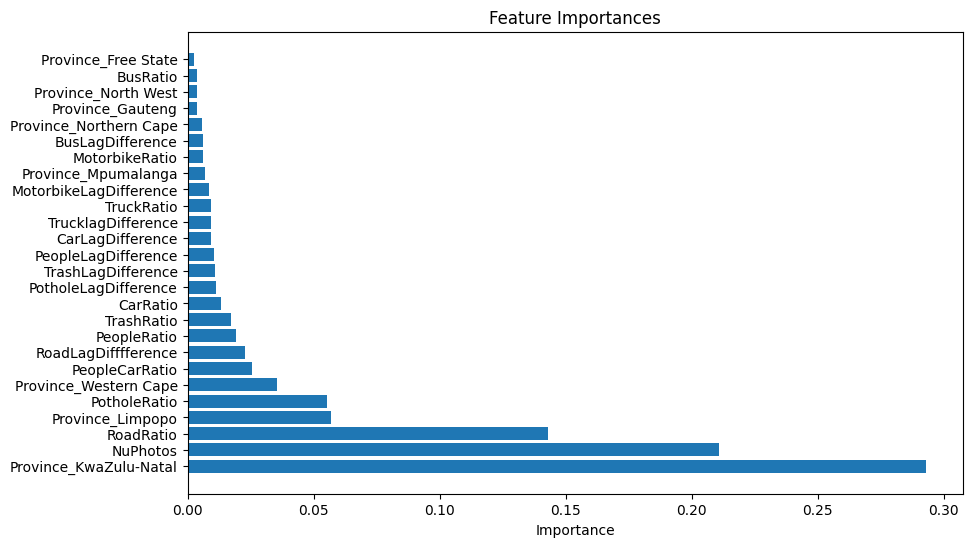

In [44]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()


# Notes

## All
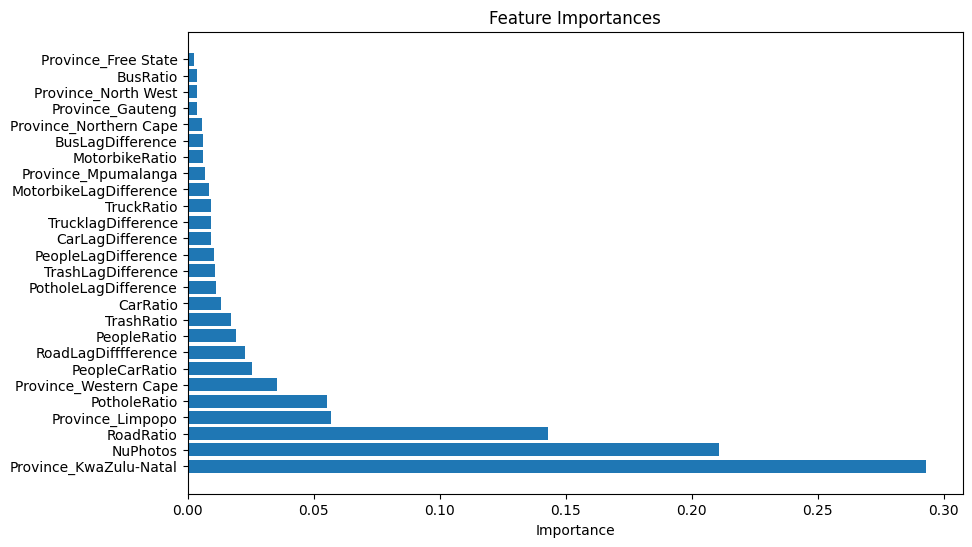



## Metro
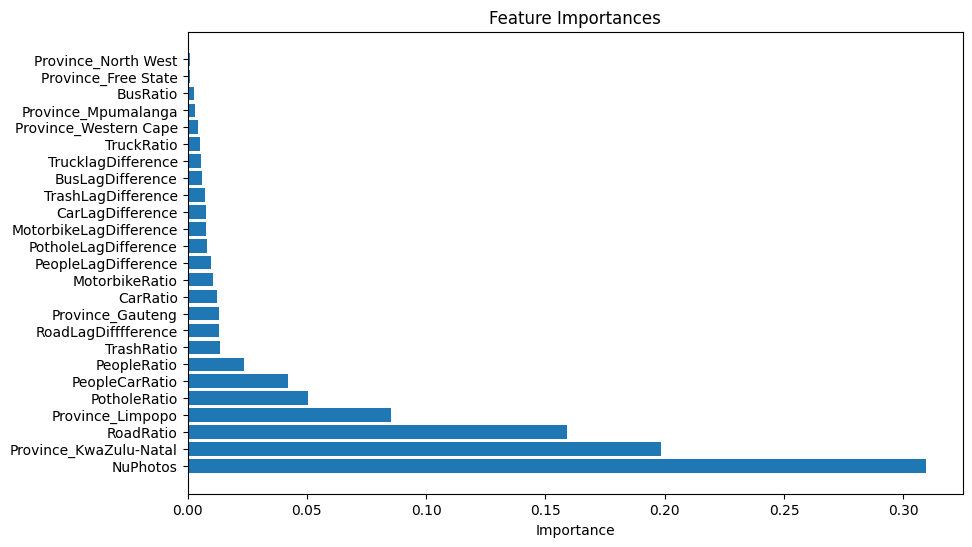

# Those correlation functions from above

## Correlations Functions

In [45]:
def CorrelationCreation(attributes, df, Number, Threshold):
    # Compute Pearson and Spearman correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    corr_matrix_spearman = df[attributes].corr(method='spearman')

    top_pearson_threshold = corr_matrix_pearson[attributes[0]].apply(abs)  # Calculate absolute correlation values
    top_pearson_threshold = top_pearson_threshold[top_pearson_threshold > Threshold].sort_values(ascending=False).index.tolist()  # Filter for correlation > Threshold
    top_pearson_threshold = [feature for feature in top_pearson_threshold if feature != attributes[0]]  # Remove the target column
    corr_matrix_pearson = df[[attributes[0]]+top_pearson_threshold].corr(method='pearson')

    top_spearman_threshold = corr_matrix_spearman[attributes[0]].apply(abs)  # Calculate absolute correlation values
    top_spearman_threshold = top_spearman_threshold[top_spearman_threshold > Threshold].sort_values(ascending=False).index.tolist()  # Filter for correlation > Threshold
    top_spearman_threshold = [feature for feature in top_spearman_threshold if feature != attributes[0]]  # Remove the target column
    corr_matrix_spearman = df[[attributes[0]]+top_spearman_threshold].corr(method='spearman')

    # Print Pearson correlation for the first attribute
    print("\nPearson Correlation")
    print(corr_matrix_pearson[attributes[0]].sort_values(ascending=False))

    # Print Spearman correlation for the first attribute
    print("\nSpearman Correlation")
    print(corr_matrix_spearman[attributes[0]].sort_values(ascending=False))

    # Plotting the top x
    TempNumber = Number
    if(TempNumber > len(top_pearson_threshold)):
        TempNumber = len(top_pearson_threshold)

    top_pearson = corr_matrix_pearson[attributes[0]].apply(abs).sort_values(ascending=False).head(TempNumber).index.tolist()[1:]

    TempNumber = Number
    if(TempNumber > len(top_spearman_threshold)):
        TempNumber = len(top_spearman_threshold)
    top_spearman = corr_matrix_spearman[attributes[0]].apply(abs).sort_values(ascending=False).head(Number).index.tolist()[1:]

    # Get the top 8 features to plot
    corr_matrix_pearson_top = corr_matrix_pearson.loc[top_pearson, top_pearson]
    corr_matrix_spearman_top = corr_matrix_spearman.loc[top_spearman, top_spearman]

    # Set up figure for heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Pearson Correlation Heatmap
    sns.heatmap(corr_matrix_pearson_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
    axes[0].set_title("Pearson Correlation Heatmap")

    # Spearman Correlation Heatmap
    sns.heatmap(corr_matrix_spearman_top, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title("Spearman Correlation Heatmap")

    # Tight layout for heatmaps
    plt.tight_layout()
    plt.show()



    return top_pearson, top_spearman, top_pearson_threshold, top_spearman_threshold


In [46]:
def feature_reduction(attributes, df, threshold=0.9):
    # Compute Pearson correlation matrices
    corr_matrix_pearson = df[attributes].corr(method='pearson')
    
    # Get the correlation with the target column
    corr_with_target_pearson = corr_matrix_pearson[attributes[0]].apply(abs)

    # Step 1: Identify multicollinear features (above the threshold)
    features_to_remove = set()
    for i in range(len(attributes)):
        for j in range(i + 1, len(attributes)):  # Only check the upper triangle to avoid redundancy
            if abs(corr_matrix_pearson.iloc[i, j]) > threshold:  # If the correlation is greater than the threshold
                feature_i = attributes[i]
                feature_j = attributes[j]
                
                # Step 2: Keep the feature most correlated with the target
                if corr_with_target_pearson[feature_i] >= corr_with_target_pearson[feature_j]:
                    features_to_remove.add(feature_j)
                else:
                    features_to_remove.add(feature_i)

    # Step 3: Filter out multicollinear features and keep the ones most related to the target
    attributes_cleaned = [feature for feature in attributes if feature not in features_to_remove]

    # Return the remaining features after reduction
    return attributes_cleaned
